In [2]:
import utils

## Setup Config

In [ ]:
from configs.loca_config import get_config

config = get_config()
config.batch_size = 1
config.dataset_configs.shuffle = False

## Setup Dataset

In [ ]:
from scenic.train_lib import train_utils
import jax.numpy as jnp
import loca_dataset
import ops
import jax
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.75'
os.environ['TFDS_DATA_DIR'] = '/home/admin/john/data/tensorflow_datasets'

rng = jax.random.key(77)
data_rng, rng = jax.random.split(rng)

dataset = train_utils.get_dataset(config, data_rng)

In [ ]:
# dataset.train_ds[0]

import itertools

# Get the nth element (e.g., 5th)
generator = (x for x in range(100))
nth_element = next(itertools.islice(dataset.train_iter, 4, 5), None)
nth_element['id']

In [ ]:
# dataset.train_ds[0]

import itertools

# Get the nth element (e.g., 5th)
generator = (x for x in range(100))
nth_element = next(itertools.islice(dataset.train_iter, 4, 5), None)
nth_element['reference'][0, 0, 0, 0, 0]

# Something

In [ ]:
def remove_batch_dim0(batch, debug=False):
    # Remove dim 0. (Don't know where extra dim is added at 0)
    for k, v in batch.items():
        batch[k] = v.squeeze(0)
        if debug:
            print(f"batch[{k}]: {batch[k].shape}")

    return batch

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from configs.loca_config import SENTINEL2_L1C_MEAN, SENTINEL2_L1C_STD, SENTINEL2_L2A_MEAN, SENTINEL2_L2A_STD
import visualisation_utils as viz_utils

batch = next(dataset.train_iter)

batch = remove_batch_dim0(batch)
prepped_batch = utils.prepare_input(batch, config)

batch_idx = 1
q_idx = 0

fig = plt.figure(figsize=(5, 5))

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[0.4, 1])

gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[0])


# Visualise reference RGB
# fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

ref_s2_img = prepped_batch['reference'][batch_idx, :, :, 9:21]
is_l2a = batch['is_l2a'][batch_idx]

if is_l2a:
    ref_s2_img = (ref_s2_img * jnp.array(SENTINEL2_L2A_STD) + jnp.array(SENTINEL2_L2A_MEAN))
else:
    ref_s2_img = (ref_s2_img * jnp.array(SENTINEL2_L1C_STD) + jnp.array(SENTINEL2_L1C_MEAN))


# Visualise query
q_s2_img = batch['query1'][batch_idx, :, :, 9:21]

if is_l2a:
    q_s2_img = (q_s2_img * jnp.array(SENTINEL2_L2A_STD) + jnp.array(SENTINEL2_L2A_MEAN))
else:
    q_s2_img = (q_s2_img * jnp.array(SENTINEL2_L1C_STD) + jnp.array(SENTINEL2_L1C_MEAN))


global_min = jnp.minimum(
    ref_s2_img.min(axis=(0, 1)), 
    q_s2_img.min(axis=(0, 1))
)
global_max = jnp.maximum(
    ref_s2_img.max(axis=(0, 1)), 
    q_s2_img.max(axis=(0, 1))
)


ref_s2_img = (ref_s2_img - global_min) / (global_max - global_min)
ref_s2_img = jnp.array(ref_s2_img * 255, dtype="uint8")

q_s2_img = (q_s2_img -  global_min) / (global_max - global_min)
q_s2_img = jnp.array(q_s2_img * 255, dtype="uint8")



# Visualise query bbox
# Get query bbox coordinates from batch
query_bbox = batch['query1_box'][batch_idx] * 224  # Multiplied by img size
_, y, x, h, w = query_bbox

# Create rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the plot
ax2.add_patch(rect)


ax1.imshow(q_s2_img[:, :, [3, 2, 1]])
ax2.imshow(ref_s2_img[:, :, [3, 2, 1]])

del ref_s2_img, q_s2_img

In [ ]:
q_s2_img.shape

In [ ]:
patch_size = 16
kept_indices = [0, 1, 2, 3]
opacity = 0.1
img = q_s2_img[:, :, [3, 2, 1]]
height, width, channels = img.shape  # Note: Make sure this ordering is correct!
num_patches_h = height // patch_size
num_patches_w = width // patch_size
total_patches = num_patches_h * num_patches_w

# Create a mask for the opacity (1.0 for selected patches, opacity_factor for others)
mask = jnp.ones((num_patches_h, num_patches_w)) * opacity  # Initialize all to opacity

# Convert flat indices to 2D patch coordinates and set selected patches to 1.0
for idx in kept_indices:
    patch_i = idx // num_patches_w
    patch_j = idx % num_patches_w
    print(f"Keeping patch at ({patch_i}, {patch_j})")
    mask = mask.at[patch_i, patch_j].set(1.0)

# Use Kronecker product for cleaner expansion
mask_expanded = jnp.kron(mask, jnp.ones((patch_size, patch_size)))
print(mask_expanded)

# Add channel dimension
mask_final = mask_expanded[:, :, jnp.newaxis]

# Apply mask to the image
alpha = mask_final  # Already has shape (height, width, 1)
rgb = img
result = jnp.concatenate([rgb, alpha], axis=2)

print(f"Final image shape: {result.shape}")

In [ ]:
from configs.loca_config import SENTINEL1_MEAN, SENTINEL1_STD, DEM_MEAN, DEM_STD

q_s1_img = batch['query1'][batch_idx, :, :, 1:9]
q_s1_img = (q_s1_img * jnp.array(SENTINEL1_STD) + jnp.array(SENTINEL1_MEAN))

q_s1_img = (q_s1_img - q_s1_img.min(axis=(0, 1))) / (q_s1_img.max(axis=(0, 1)) - q_s1_img.min(axis=(0, 1)))
q_s1_img = jnp.array(q_s1_img * 255, dtype="uint8")

dem = batch['query1'][batch_idx, :, :, 0]
# print(batch['query1'][batch_idx, :, :, 0].shape)
dem = (dem * jnp.array(DEM_STD)) + jnp.array(DEM_MEAN)
dem = (dem - dem.min(axis=(0, 1))) / (dem.max(axis=(0, 1)) - dem.min(axis=(0, 1)))
dem = jnp.array(dem * 255, dtype="uint8")
print(dem.shape)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))

ax1.imshow(img)
ax2.imshow(q_s1_img[:, :, 0])
ax3.imshow(dem, cmap='gray')
ax4.imshow(jnp.repeat(dem[:, :, None], 3, axis=2), cmap='gray')

In [ ]:
jnp.all(batch['query1'][batch_idx, :, :, 0] == batch['query1'][batch_idx, :, :, 1])

In [ ]:
query = batch['query1'][batch_idx]
h, w, c = query.shape

patch, _ = config.model.patches.size
hp, wp = h // patch, w // patch

key = jax.random.key(seed=41)
idx_kept_groups = jax.random.randint(key, (hp, wp), minval=0, maxval=5, dtype=jnp.int32)

# vis_img = jnp.ones(query)
# vis_img.shape

In [ ]:
idx_kept_groups.shape, idx_kept_groups

# Setup Model

In [757]:
import flax
from flax.training import checkpoints
import optax
from scenic.train_lib import lr_schedules
import vit
import copy

config.reference_seqlen = int(1.0 * 196)
config.sen2grouped_maintain_seqlen = True
config.use_same_group_attn_mask = True

train_state = None

model = vit.ViTLOCAModel(config, dataset.meta_data)

rng = jax.random.key(64)
rng, init_rng = jax.random.split(rng)
(params, _, num_trainable_params, gflops) = train_utils.initialize_model(
    model_def=model.flax_model,
    input_spec=[
        (dataset.meta_data['input_shape'], dataset.meta_data.get('input_dtype', jnp.float32))],
    config=config, rngs={'params': init_rng, 'changroup': init_rng}
)

# Only one model function but two sets of parameters.
ema_params = copy.deepcopy(params)

learning_rate_fn = lr_schedules.get_learning_rate_fn(config)
momentum_parameter_scheduler = lr_schedules.compound_lr_scheduler(
  config.momentum_rate)

weight_decay_mask = jax.tree_util.tree_map(lambda x: x.ndim != 1, params)
tx = optax.inject_hyperparams(optax.adamw)(
  learning_rate=learning_rate_fn, weight_decay=config.weight_decay,
  mask=weight_decay_mask)

opt_state = jax.jit(tx.init, backend='cpu')(params)

chrono = train_utils.Chrono()

train_state = utils.TrainState(
  global_step=0, opt_state=opt_state, tx=tx, params=params,
  ema_params=ema_params, rng=rng, metadata={'chrono': chrono.save()})

checkpoint_path = '/home/admin/john/scenic/loca_s1_s2_dem_attn_masking_enc_cross_1_0_masking/checkpoint_468700'
# checkpoint_path = '/home/admin/john/scenic/loca_s1_s2_dem_attn_masking_enc_cross_0_4_masking/checkpoint_468700'
# checkpoint_path = '/home/admin/john/scenic/loca_s1_s2_dem_attn_masking_enc_cross_0_0_masking/checkpoint_468700'
# checkpoint_path = '/home/admin/satellite-loca/scenic/loca_ft_from_scratch'
train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

# Run Inference

In [758]:
# batch = next(dataset.train_iter)

# batch = remove_batch_dim0(batch)
# prepped_batch = utils.prepare_input(batch, config)

In [759]:
batch_idx = 0

In [760]:
dropout_rng, droptok_rng, changroup_rng = jax.random.split(rng, num=3)

use_ema = True
drop_moment = "late"

_, r_feat_targets, r_patch_features, r_idx_kept_tokens, _, r_idx_kept_groups  = model.flax_model.apply(
    {'params': train_state.ema_params if use_ema else train_state.params},
    jnp.expand_dims(prepped_batch['reference'][batch_idx], 0),
    seqlen=config.reference_seqlen,
    seqlen_selection=config.reference_seqlen_selection,
    drop_moment=drop_moment,
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng}
)

n_q_foc = config.dataset_configs.number_of_focal_queries
use_pe = False

q_foc_loc_pred, q_foc_feat_pred, _, _, num_channels, q_idx_kept_groups = model.flax_model.apply(
    {'params': train_state.params},
    jnp.expand_dims(batch[f'query3'][batch_idx], 0),
    inputs_kv=r_patch_features,
    use_pe=use_pe,
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng})

del r_feat_targets, r_patch_features, q_foc_feat_pred

In [761]:
from visualisation_utils import visualize_reference_query_pair
q, r = visualize_reference_query_pair(batch, patch_size=16, batch_idx=batch_idx, query_idx=2,
                                  ref_idx_kept_tokens=r_idx_kept_tokens, ref_idx_kept_groups=r_idx_kept_groups, 
                                  q_idx_kept_groups=q_idx_kept_groups)

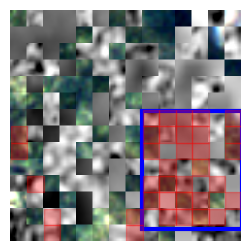

In [762]:
fig, (ax2) = plt.subplots(1, 1, figsize=(3, 3))
ax2.axis('off')

# ax2.imshow(q)

# Visualise query bbox
# Get query bbox coordinates from batch
query_bbox = batch['query3_box'][batch_idx] * 224  # Multiplied by img size
_, y, x, h, w = query_bbox

# Create rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='b', facecolor='none')
ax2.add_patch(rect)

###
inds = jnp.arange(14 * 14).reshape(14, 14)
loc_pred = q_foc_loc_pred.squeeze().argmax(axis=1)

for pred in loc_pred:
    row, col = jnp.where(inds == pred)
    if row.size < 1:
        continue
    row, col = row.item(), col.item()

    cell_width, cell_height = 224 // 14, 224 // 14

    rect = patches.Rectangle((col * cell_width, row * cell_height), 
                               cell_width, cell_height,
                                edgecolor='red',
                               facecolor="red", 
                               alpha=0.3)
    ax2.add_patch(rect)


ax2.imshow(r)

In [763]:
fig.savefig('images/sample12_1_0_mixed', dpi=500)

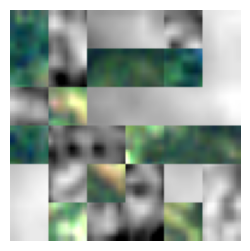

In [755]:
fig_q, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.axis('off')
ax.imshow(q)

In [756]:
# fig_q.savefig('images/sample12_query_mixed', dpi=500)

In [ ]:
batch['query4_box'][0] * 224
# r.shape
q_foc_loc_pred.squeeze().argmax(axis=1).shape

In [ ]:
mean = jnp.array([750.3643697290039, -11.673448681503809, -19.04684937464606, -10.525772696311732, -19.532663009778172,
                  -11.754322832475555, -19.187027531976366, -11.729595910348051, -21.294408727496148, 1349.3977794889083, 1479.9521800379623, 1720.3688077425966, 1899.1848715975957,
                      2253.9309600057886, 2808.2001963620132, 3003.424149045887, 3149.5364927329806,
                      3110.840562275062, 3213.7636154015954, 2399.086213373806,
                      1811.7986415136786])
std = jnp.array([975.1516800116567, 5.1287824026286755, 6.432180454976982, 5.646047662186715, 7.724311760316525,
                 5.01231147683192, 6.296322894653895, 5.348371323330351, 7.184819430273331, 2340.2916479338087, 2375.872101251672, 2256.8997709659416, 2354.181051828758,
                     2292.99569489449, 2033.2166835293804, 1920.1736418230105, 1816.6152354201365,
                     1988.1938283738782, 1947.9031620588928, 1473.224812450967,
                     1390.6781165633136])